## **ML1 PROJECT 2** ##
Randy Kim, Kati Schuerger, Will Sherman 


## **INTRODUCTION** ##

**Identify two tasks from our dataset to predict:**

1. Classification task = predict quart_binary (0/1). This variable is equal to 1 when the player's score is in the 4th quantile.


2. Regression task = predict winPlacePerc. This variable will require a regression model analyzing the mean absolute error (MAE). Consequently, this was the same metric for the kaggle competition's QOI. (Alternative wording: Our second task will be regressing what the player's win place percent will be, given their performance on other metrics gathered during the game.) 

**Try to use as much testing data as possible in a realistic manner.**

For hyperparameter tuning, we used a subset of our training data, because we ran into very lengthy run-time when attempting to perform tuning on the full training set. To help decrease the run-time, a subsample of 10% of the train data was made. This will still represent about 270,000 records, which is sufficient for our analysis and modeling. 

As long as the sample size is greater than 30, we can leverage the CLT, which allows us to make inferences about our population by using a sampling of the data.


# **BUSINESS UNDERSTANDING** #

*Context for our classification and regression tasks.*

The **PlayerUnknown’s Battleground** (also known as PUBG) **Finish Placement Prediction** Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." This competition utilized publicly available official game data from PUBG through the PUBG Developer API. The questions of interest (QOI) were about the best strategy to win in PUBG, the best skillset, and to be able to model ranking in-game. The dataset provided was a breakdown of post-game metrics and percentile winning placement: with 4446966 records and 29 total features.

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

We want to predict the two following things: winPlacePerc (continuous variable), and winPlaceQuartile (categorical variable). winPlacePerc is a ranking of a “players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." winPlaceQuartile is a new categorical variable we are adding to the dataset. This variable will have four categories, one for each quartile.

For the first response (classification task), winPlaceQuartile, we will measure accuracy in combination with 10-fold cross-validation.

The second response (regression task), winPlacePerc, will require a regression model analyzing the mean absolute error (MAE) in combination with 10-fold cross-validation. Consequently, this was the same metric for the kaggle competition's QOI.

Creating forecasting algorithms for online sports is not new. Therefore, the combination of the two measures could be related to optimizing a sports betting algorithms. You could also use these models for building and managing an effective team for tournaments. For example, the PUBG Global Championship 2021 Grand Finals had combined prize value of over 2 million USD.

# **DATA PREPARATION**

## Set up environment

In [1]:
# load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statistics
import time

# import libraries to clean up CopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# load in the data
pubg_raw = pd.read_csv("train_V2.csv")

# for kati local run
# pubg_raw = pd.read_csv(r"C:\Users\kschue200\OneDrive - Comcast\Documents\00 SMU\00 machine learning1\mini lab\train_V2.csv")

# for will local run
# pubg_raw = pd.read_csv(r"C:\Users\sherm\OneDrive\Documents\Grad School - Classes\MSDS - 7331 - Machine Learning I\Lab 1\pubg-finish-placement-prediction\train_V2.csv")

In [3]:
# this logic iterates through the DF to reduce memory usage
# code adapted from https://www.kaggle.com/yansun1996/gbr-ipynb
# additional reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
pubg_raw = reduce_mem_usage(pubg_raw)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


## Data definitions

The variables of type integer are *assists*, *boosts*, *DBNO*s, *headshotKills*, *heals*, *killPlace*, *killPoints*, *kills*, *killStreaks*, *matchDuration*, *maxPlace*, *numGroups*, *rankPoints*, *revives*, *roadKills*, *teamKills*, *vehicleDestroys*, *weaponsAcquired*, and *winPoints*.

·       DBNOs - Number of enemy players knocked. DBNO means “down but not out.” Essentially, “knocked” means to be knocked out. When a player is knocked, they lose their ability to shoot, move quickly, and to hold a gun. Players do not die instantly when knocked, when playing in a group (on a team) - other members of the team can revive a knocked player. (do we need this last line?)

·       assists - Number of enemy players this player damaged that were killed by teammates.

·       boosts - Number of boost items used. Boost items are things that improve a player’s health, examples are energy drinks, painkillers, and adrenaline syringes.

·       damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

·       headshotKills - Number of enemy players killed with headshots. 

·       heals - Number of healing items used.
·       Id - Player’s Id

·       killPlace - Ranking in match of number of enemy players killed.

·       killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

·       killStreaks - Max number of enemy players killed in a short amount of time.

·       kills - Number of enemy players killed.

·       longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

·       matchDuration - Duration of match in seconds.

·       matchId - ID to identify match. There are no matches that are in both the training and testing set.

·       matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

·       rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

·       revives - Number of times this player revived teammates.

·       rideDistance - Total distance traveled in vehicles measured in meters.

·       roadKills - Number of kills while in a vehicle.
·       swimDistance - Total distance traveled by swimming measured in meters.

·       teamKills - Number of times this player killed a teammate.

·       vehicleDestroys - Number of vehicles destroyed.

·       walkDistance - Total distance traveled on foot measured in meters.

·       weaponsAcquired - Number of weapons picked up.

·       winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

·       groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

·       numGroups - Number of groups we have data for in the match.

·       maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

·       winPlacePerc - The target of the regression. This is a continuous value of percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match. (Higher is better.)

·       quart_binary - The target of the classification. This is a binary analysis of players who placed in the top 25% are given value of 1; the bottom 75% are given value of 0. This feature was created from winPlacePerc.

*Definitions pulled from Kaggle*: https://www.kaggle.com/c/pubg-finish-placement-prediction/data

*Additional details added to elaborate on/clarify some of the variables.*

## Data preparation

In the below section we will handle records with missing values (chosen methos = drop from data), create new variables for our classification task, remove unuseful object-datatype variables, and remove features that introduce convergence issues in our models.

In [5]:
pubg_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


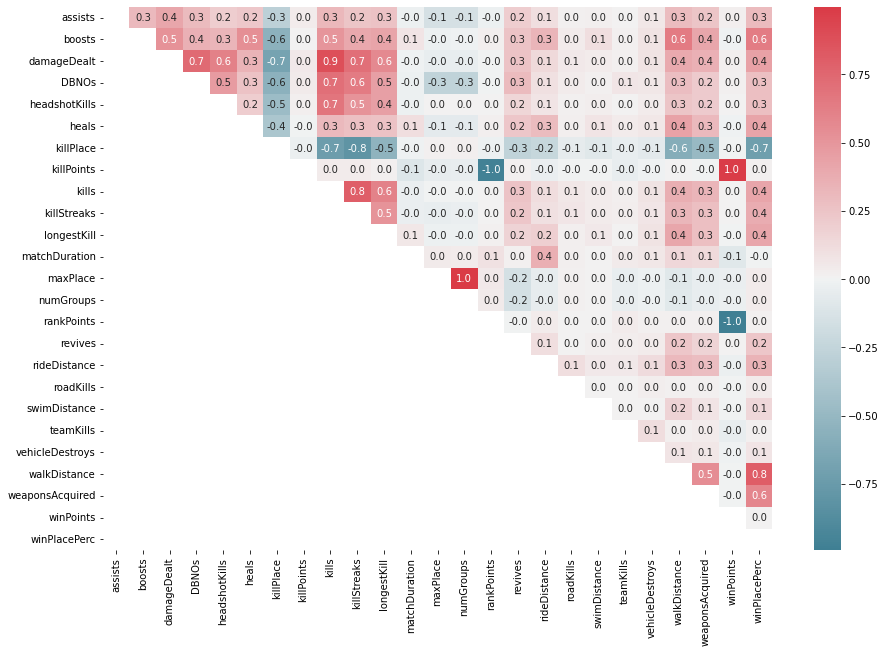

In [6]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_raw.corr()
heatPlot = sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
                       mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))
plt.show()

Based on our analysis, we dropped the single missing value for a match that had only 1 individual (above).

We also identified *unranked* matches as creating significant issues in prediction capabilities (below). We resolved to remove these from our model. Therefore, our model should only be applied to **ranked** matches. 

### Check for missing values

In [7]:
# check for misssing values
colname = list(pubg_raw.columns)

for i in range(len(pubg_raw.columns)):
  count = pubg_raw[pubg_raw.columns[i]].isna().sum()
  print("Column '{col}' has {ct} NAs".format(col = colname[i], ct = count))

Column 'Id' has 0 NAs
Column 'groupId' has 0 NAs
Column 'matchId' has 0 NAs
Column 'assists' has 0 NAs
Column 'boosts' has 0 NAs
Column 'damageDealt' has 0 NAs
Column 'DBNOs' has 0 NAs
Column 'headshotKills' has 0 NAs
Column 'heals' has 0 NAs
Column 'killPlace' has 0 NAs
Column 'killPoints' has 0 NAs
Column 'kills' has 0 NAs
Column 'killStreaks' has 0 NAs
Column 'longestKill' has 0 NAs
Column 'matchDuration' has 0 NAs
Column 'matchType' has 0 NAs
Column 'maxPlace' has 0 NAs
Column 'numGroups' has 0 NAs
Column 'rankPoints' has 0 NAs
Column 'revives' has 0 NAs
Column 'rideDistance' has 0 NAs
Column 'roadKills' has 0 NAs
Column 'swimDistance' has 0 NAs
Column 'teamKills' has 0 NAs
Column 'vehicleDestroys' has 0 NAs
Column 'walkDistance' has 0 NAs
Column 'weaponsAcquired' has 0 NAs
Column 'winPoints' has 0 NAs
Column 'winPlacePerc' has 1 NAs


In [8]:
# look at records with null values
pubg_raw[pubg_raw.isna().any(axis = 1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [9]:
# CREATE PUBG_DF_STG TO INCLUDE OUR UPDATES
# drop records with missing values (there is only one)
pubg_df_stg = pubg_raw.dropna()
pubg_df_stg.isnull().values.any()

False

In [10]:
# we have some records with -1 values = these take the place of NULL

x = pubg_df_stg['rankPoints']
y = pubg_df_stg['winPoints']
z = pubg_df_stg['killPoints']

print(x[x==-1].count())
print(y[y==-1].count())
print(z[z==-1].count())
print(pubg_df_stg.shape[0]-x[x==-1].count())

1701810
0
0
2745155


In [11]:
# SUBSET OUR DATA TO ONLY RETAIN RANKED MATCHES
# we have some records with -1 values = take the place of NULL
## dropping these to subset our dataset & because they represent non-ranked matches

pubg_df = pubg_df_stg[(pubg_df_stg.iloc[:,:] != -1).all(axis=1)]
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987


### Check for duplicate values

In [12]:
# check for duplicate records
pubg_df.duplicated().any()

False

### Create new quartile variables

In [13]:
# GATHER THRESHOLDS FOR US TO SET OUR QARTILES 
# pull out the winPlacePerc column
winPlace = pubg_df.loc[:,'winPlacePerc']

# get quartile thresholds for equal allocation |
print('Quartile 1 threshold: {:.2f}'.format(winPlace.quantile(0.25)))
print('Quartile 2 threshold: {:.2f}'.format(winPlace.quantile(0.5)))
print('Quartile 3 threshold: {:.2f}'.format(winPlace.quantile(0.75)))

Quartile 1 threshold: 0.20
Quartile 2 threshold: 0.46
Quartile 3 threshold: 0.74


In [14]:
# create new variable fields to use for our predictions (quartile, quart_int, quart_binary)
# we will use quart_binary for our classification task in this mini-lab

pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.46, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.74, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, 'q4',
                                                  'other'))))
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1', 
                       np.where(pubg_df.winPlacePerc < 0.46, '2',
                                np.where(pubg_df.winPlacePerc < 0.74, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '4',
                                                  'other'))))
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.74, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '1',
                                                  'other'))
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,11.039062,0,0,1434.0000,5,0,0.640137,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0.000000,0,0,161.7500,2,0,0.775391,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0.000000,0,0,202.7500,3,0,0.166748,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0.000000,0,0,49.7500,2,0,0.187500,q1,1,0
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0.000000,0,0,34.6875,1,0,0.036987,q1,1,0


In [15]:
# check the spread of our quartiles
# make sure they are balanced

quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 24.86%
Percentage of players in Quartile 2: 25.19%
Percentage of players in Quartile 3: 24.55%
Percentage of players in Quartile 4: 25.41%
Miscategorized quartile values:   0


### Remove unuseful variables

In [16]:
# remove some unuseful object-datatype variables 
del pubg_df['Id']
del pubg_df['groupId']
del pubg_df['matchId']
del pubg_df['matchType']

In [17]:
# FEATURE COLUMN NAMES 
# make a list of the columns in our df (to be used for models below)

cols_df = pubg_df.columns.values.tolist()
cols_df.remove('winPlacePerc') # remove target variable 1 (continuous)
cols_df.remove('quartile') # remove target variable 2 (categorical)
cols_df.remove('quart_int') # remove target variable 2 (numeric representation)
cols_df.remove('quart_binary')
print(cols_df)

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']


<AxesSubplot:>

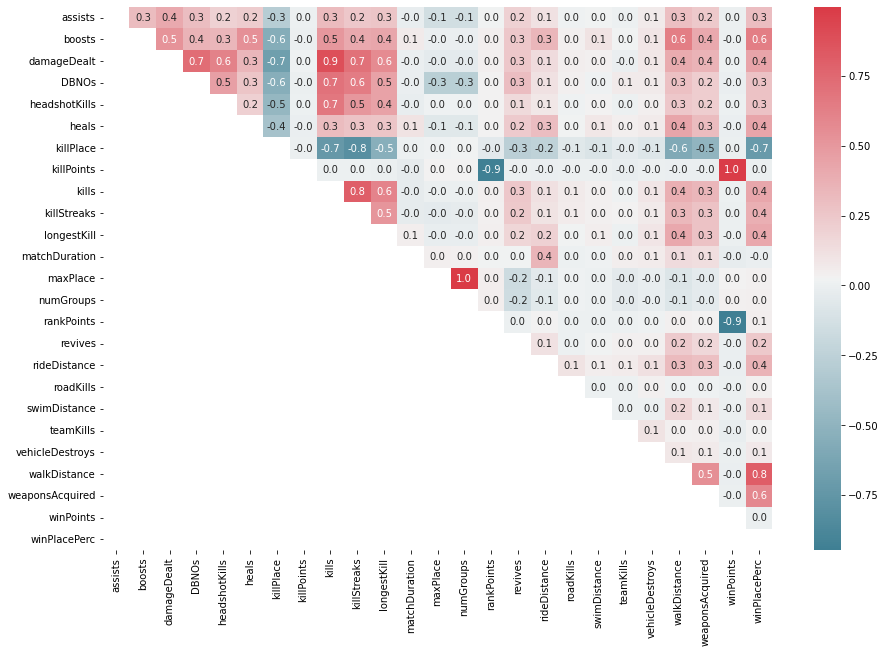

In [18]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_df.corr()
sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
            mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))

In [19]:
# remove additional variables that are causing extra noise in our model
# (specifically, these variables are highly correlated with other variables 
# which impacts our model's convergence perfomance)

cols_df.remove('winPoints') # highly correlated with rankPoints and killPoints
cols_df.remove('killPoints') # highly correlated with rabnkPoints and winPoints
cols_df.remove('maxPlace') # perfectly correlated with numGroups
print(cols_df)

# We maintain the rankPoints variable since we subset on this earlier to only work with 'ranked' matches

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired']


### Final dataframe for models

In [20]:
temp = pubg_df[cols_df]
temp['winPlacePerc'] = pubg_df['winPlacePerc']
temp['quart_binary'] = pubg_df['quart_binary']
finalDF = temp
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745155 entries, 1 to 4446965
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   kills            int8   
 8   killStreaks      int8   
 9   longestKill      float16
 10  matchDuration    int16  
 11  numGroups        int8   
 12  rankPoints       int16  
 13  revives          int8   
 14  rideDistance     float16
 15  roadKills        int8   
 16  swimDistance     float16
 17  teamKills        int8   
 18  vehicleDestroys  int8   
 19  walkDistance     float16
 20  weaponsAcquired  int16  
 21  winPlacePerc     float16
 22  quart_binary     object 
dtypes: float16(6), int16(3), int8(13), object(1)
memory usage: 123.0+ MB


The above df.info() confirms that we have at least 30k records and 15 columns in data. We have 2,745,155 records and 21 feature columns—2 response vectors.

# **METRIC SELECTION & DATA SPLIT**

## Performance metrics
*Choose and explain the metrics you will use to evaluate model performance.
Need to be sure that we use regression metric for regression task, and classification metric for classification task.*

1. Classification task (quart_binary): We will use accuracy to measure model performance. We chose accuracy since online gambling is primarily concerned with increasing correct bets: both the true-positive and the true-negative rates. This would correspond with accuracy as a prediction metric—a future model could **also** evaluate F1-score to evaluate "unsafe" bets.

2. Regression task (winPlacePerc): We will use mean absolute error (MAE) requiring a regression model with 10-fold cross-validation. Consequently, this was the same metric for the kaggle competition's QOI. The reason for MAE evaluation is that we are identifying how far each prediction is from reality.
useful reference: https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/


*Be sure to explain why we chose the metric in each instance. "We chose xx as evaluation metric for classification task because...."*

## Tran/test split logic

Our chosen method for splitting the data is the holdout method (train, test, validation split).

We have chosen to split our data into 3 parts: a train set, a test set, and a validation set. 
We will use them as folows:
- **train set:** to fit the different models
- **validation set:** to assess model performance and for model selection
- **test set:** to assess how well our model generalizes to unseen data 

Why did we decide to split into 3 groups? 
When we only split into training/testing sets, and continue to assess model performance on the test data, that test data essentially becomes part of our training data, which means that it does not do as good a job of giving us insight into how well our model will generalize to unseen data.

"One disadvatage of the holdout method is that the performance estimate is sensitive to how we partition the training set into the training and validation subsets; the estimate will vary for different samples of the data."


*Reference: Python Machine Learning - Raschka (p.174)*

**Breakdown:** 70% train, 20% validate, 10% test.



**Hyperparameter Data:** 10% sample size randomly taken from training data.

In [21]:
# TRAIN TEST SPLIT
# reference: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# creation of feature-space and response-vectors
dataX = finalDF.loc[:, cols_df]
dataY = finalDF.loc[:, ('winPlacePerc','quart_binary')]

# train is now 70% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=(1-train_ratio))

# test is now 10% of the initial data set
# validation is now 20% of the initial data set 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print("Training Data shape:   ", x_train.shape)
print("Validating Data shape: ", x_val.shape)
print("Test Data shape:       ", x_test.shape)

Training Data shape:    (1921608, 21)
Validating Data shape:  (549031, 21)
Test Data shape:        (274516, 21)


In [22]:
indices = x_train.sample(n=50000, replace=False, random_state=17).index
x_tune = x_train.loc[indices, :]
y_tune = y_train.loc[indices, :]

print("Tuning Data shape: ", x_tune.shape)
print(dataY[dataY.quart_binary=='1'].shape)
print(dataY[dataY.quart_binary=='0'].shape)
print(y_tune[y_tune.quart_binary=='1'].shape)
print(y_tune[y_tune.quart_binary=='0'].shape)

Tuning Data shape:  (50000, 21)
(697494, 2)
(2047661, 2)
(12751, 2)
(37249, 2)


This distribution between our training data and our tuning data appear fairly symmetric. The tuning data will be used for hyperparameter tuning.

Side note: We could have used stratified shuffle split, but chose not to. Stratified shuffle split is useful when you have unbalanced data representation across the classes you are attempting to predict. Stratified shuffle split will lock in the class distribution for the train/test split. The only place this might be useful for our analysis would be in predicting the binary classification metric quart_binary, since we have 75% of our data = no, and 25% = yes.

*Reference:https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50*

# **BUILD MODELS + MODEL ANALYSIS**


## Task 1: Classification models

### Hyperparameter tuning: Classification models

In [23]:
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


pipe = Pipeline([("scaler", StandardScaler()),
                ("classifier", RandomForestClassifier())])

grid_param = [
    {"classifier": [RandomForestClassifier(random_state=17)],
    "classifier__n_estimators": [50,100,200],
    "classifier__criterion":["gini", "entropy"],
    "classifier__max_features": ['auto','sqrt','log2'],
    "classifier__max_depth": [4,5,6,7,8,9]
    },
    {"classifier": [LogisticRegression(random_state=17)],
    "classifier__penalty": ["l2"],
    "classifier__C": np.logspace(-1, 4, 8),
    "classifier__solver":["newton-cg", "saga", "sag", "liblinear"],
    "classifier__max_iter": [10, 100, 1000]
    },
    # {"classifier": [SVC(random_state=17)],
    # "classifier__kernel": ["linear","rbf","sigmoid"],
    # "classifier__max_iter": np.logspace(0,3,4),
    # "classifier__C": np.logspace(-1,4,6),
    # "classifier__gamma": ['scale','auto']
    # },
    # {"classifier": [KNeighborsClassifier()],
    # "classifier__n_neighbors": [1, 3, 5],
    # "classifier__weights": ["uniform", "distance"],
    # "classifier__algorithm": ["auto", "brute"],
    # "classifier__leaf_size": [0, 10, 20, 30]
    # },
    {"classifier": [GaussianNB()],
    "classifier__var_smoothing": np.logspace(-11,-4,8)
    }
]

Pick best classifier parameters using gridsearch. 
We will fit the model on the TUNE data.

In [24]:
gridsearch = GridSearchCV(pipe, grid_param, cv = 5, verbose = 0, n_jobs = -1)
best_model = gridsearch.fit(x_tune, y_tune['quart_binary'])

**Best model for classification task.**

In [25]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(x_tune, y_tune['quart_binary']))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=9,
                                        n_estimators=200, random_state=17))])
The mean accuracy of the model is: 0.9205


In [26]:
df = pd.DataFrame(best_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,param_classifier__C,...,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.947977,0.031863,0.109706,0.006181,"RandomForestClassifier(criterion='entropy', ma...",gini,4,auto,50,NaN,...,NaN,{'classifier': RandomForestClassifier(criterio...,0.8978,0.8929,0.8888,0.8953,0.8974,0.89444,0.003316,187
1,3.782671,0.041050,0.173536,0.005536,"RandomForestClassifier(criterion='entropy', ma...",gini,4,auto,100,NaN,...,NaN,{'classifier': RandomForestClassifier(criterio...,0.8965,0.8919,0.8881,0.8950,0.8969,0.89368,0.003298,193
2,8.111941,0.437317,0.374998,0.036328,"RandomForestClassifier(criterion='entropy', ma...",gini,4,auto,200,NaN,...,NaN,{'classifier': RandomForestClassifier(criterio...,0.8967,0.8918,0.8887,0.8950,0.8963,0.89370,0.003035,190
3,2.035756,0.044168,0.111503,0.006686,"RandomForestClassifier(criterion='entropy', ma...",gini,4,sqrt,50,NaN,...,NaN,{'classifier': RandomForestClassifier(criterio...,0.8978,0.8929,0.8888,0.8953,0.8974,0.89444,0.003316,187
4,4.280953,0.207046,0.186103,0.021932,"RandomForestClassifier(criterion='entropy', ma...",gini,4,sqrt,100,NaN,...,NaN,{'classifier': RandomForestClassifier(criterio...,0.8965,0.8919,0.8881,0.8950,0.8969,0.89368,0.003298,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.667496,0.353851,0.036103,0.001716,LogisticRegression(random_state=17),NaN,NaN,NaN,NaN,10000.0,...,newton-cg,{'classifier': LogisticRegression(random_state...,0.9053,0.9040,0.8984,0.9002,0.9038,0.90234,0.002598,113
201,2.845988,0.103318,0.030120,0.008425,LogisticRegression(random_state=17),NaN,NaN,NaN,NaN,10000.0,...,saga,{'classifier': LogisticRegression(random_state...,0.9054,0.9041,0.8990,0.8997,0.9040,0.90244,0.002580,68
202,1.314285,0.095480,0.041090,0.010022,LogisticRegression(random_state=17),NaN,NaN,NaN,NaN,10000.0,...,sag,{'classifier': LogisticRegression(random_state...,0.9053,0.9039,0.8987,0.9001,0.9039,0.90238,0.002525,95
203,0.895006,0.095412,0.035306,0.009023,LogisticRegression(random_state=17),NaN,NaN,NaN,NaN,10000.0,...,liblinear,{'classifier': LogisticRegression(random_state...,0.9053,0.9040,0.8984,0.9002,0.9038,0.90234,0.002598,113


### Grab best model parameters for each of the classification models.



In [27]:
# df = df[df["param_classifier"].str.contains("RandomForest")].sort_values(by="mean_test_score", ascending=False).head(1)]
# testing_model = testing[testing['param_classifier'].str.contains("RandomForest")].sort_values(by="mean_test_score", ascending=False).head(1)
# testing_model.params

df['param_classifier'] = df['param_classifier'].astype(str)

clf_result = pd.DataFrame([])
model = ["RandomForest", "LogisticRegression", "Gaussian"]

for i in model:
    df_model = df[df['param_classifier'].str.contains(i)]
    df_model[['model']] = i
    df_model[['total_fit_time']] = np.sum(df_model[['mean_fit_time']])
    df_model = df_model[["model","total_fit_time","mean_fit_time","params", "mean_test_score"]].sort_values(
        by="mean_test_score", ascending=False).head(1)

    clf_result = clf_result.append(df_model, ignore_index = True)

clf_result
clf_result.style.set_properties(subset=['params'], **{'width': '250px'})

,model,total_fit_time,mean_fit_time,params,mean_test_score
0,RandomForest,756.652223,16.285305,"{'classifier': RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=200, random_state=17), 'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200}",0.909440
1,LogisticRegression,148.926413,0.538761,"{'classifier': LogisticRegression(random_state=17), 'classifier__C': 0.1, 'classifier__max_iter': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}",0.902680
2,Gaussian,0.186103,0.186103,{'classifier': GaussianNB()},0.834320


### Model analysis: Fit models & confusion matrices for classification models


We now fit the models on the TRAIN data, and make predictions on VALIDATE data to generate a confusion matrix for each model.
We shift from TUNE to TRAIN so that we can use as much data as possible to fit our model. The TUNE data was created as a subset of the TRAIN data, so that we could have better processing time when performing hyperparameter tuning. 

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

classifier_rf = RandomForestClassifier(random_state=17, n_estimators=200, criterion="entropy", max_features="log2", max_depth=9)
classifier_rf.fit(x_train, y_train['quart_binary'])
rf_pred = classifier_rf.predict(x_val)
cm_rf = confusion_matrix(y_val['quart_binary'], rf_pred)
acc_rf = accuracy_score(y_val['quart_binary'], rf_pred) * 100
print("Confusion matrix of Random Forest Classifier is:")
print(cm_rf)
print("The score accuracy of Random Forest Classifier is {}%".format(round(acc_rf,2)))

Confusion matrix of Random Forest Classifier is:
[[384567  25003]
 [ 23723 115738]]
The score accuracy of Random Forest Classifier is 91.13%


Random Forest takes about 14 minutes to run. Accuracy is 91.1%.

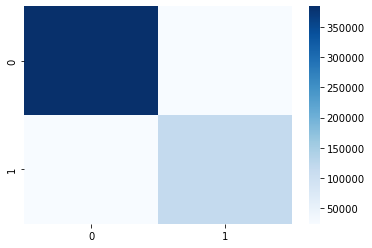

In [29]:
# Visualize confusion matrix as a heatmap 
import seaborn
seaborn.heatmap(cm_rf, cmap="Blues")
plt.show()

**Logistic Regression classification model**

In [30]:
classifier_lr = LogisticRegression(random_state=17, penalty="l2", C=0.1, solver="sag", max_iter=10)
classifier_lr.fit(x_train, y_train['quart_binary'])
lr_pred = classifier_lr.predict(x_val)
cm_lr = confusion_matrix(y_val['quart_binary'], lr_pred)
acc_lr = accuracy_score(y_val['quart_binary'], lr_pred) * 100
print("Confusion matrix of Logistic Regression is:")
print(cm_lr)
print("The score accuracy of Logistic Regression is {}%".format(round(acc_lr,2)))

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Confusion matrix of Logistic Regression is:
[[384378  25192]
 [ 31280 108181]]
The score accuracy of Logistic Regression is 89.71%


Logistic Regression takes about 20 seconds to run. Accuracy is 89.7%.

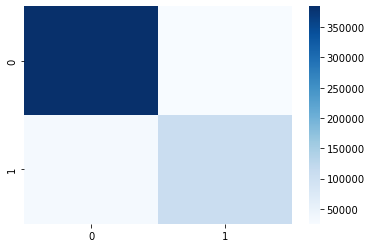

In [31]:
# Visualize confusion matrix as a heatmap 
import seaborn
seaborn.heatmap(cm_lr, cmap="Blues")
plt.show()

**Naive Bayes classification model**

In [32]:
classifier_gnb = GaussianNB()
classifier_gnb.fit(x_train, y_train['quart_binary'])
gnb_pred = classifier_gnb.predict(x_val)
cm_gnb = confusion_matrix(y_val['quart_binary'], gnb_pred)
acc_gnb = accuracy_score(y_val['quart_binary'], gnb_pred) * 100
print("Confusion matrix of Naive Bayes is:")
print(cm_gnb)
print("The score accuracy of Naive Bayes is {}%".format(round(acc_gnb,2)))

Confusion matrix of Naive Bayes is:
[[364182  45388]
 [ 42877  96584]]
The score accuracy of Naive Bayes is 83.92%


Naive Bayes takes about 6 seconds to run. Accuracy is 83.9%.

### Model analysis: ROC Curves for classification models

**ROC Curve: Random Forest**

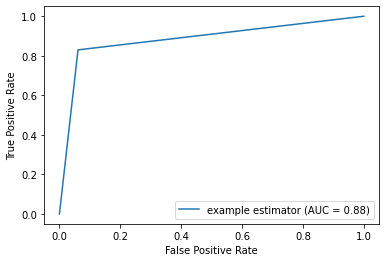

In [33]:
# ROC CURVE

import matplotlib.pyplot as plt
import numpy as np
from numpy import array 
from sklearn import metrics

# Labels are the values we want to predict
rf_labels = np.array(y_val['quart_binary'])

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # commenting out - we already ran above
# # Instantiate model using values from our gridsearch best model
# classifier_rf = RandomForestClassifier(random_state=17, n_estimators=200, criterion="entropy", max_features="log2", max_depth=9)

# # commenting out - we already ran above
# # Fit the model on training data 
# classifier_rf.fit(x_train, y_train['quart_binary'])

# Use the forest's predict method on the validate data
# store as an array so we can plot on ROC curve 
# rf_pred_stg = np.array(rf_pred.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
rf_predictions = np.stack(rf_pred).astype(None)

rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(rf_labels, rf_predictions, pos_label='1')

rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)
rf_display = metrics.RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc=rf_roc_auc,
                                   estimator_name='example estimator')
rf_display.plot()

plt.show()

**ROC Curve: Logistic Regression**

In [34]:
# get parameters for best performing models into a list
df_classifier = df.join(pd.DataFrame(df.pop('params').tolist()).fillna(0))
df_classifier['classifier'] = df_classifier['classifier'].astype(str)

In [35]:
# get parameters for logistic regression model with best performance
df_lr = df_classifier[df_classifier['classifier'].str.contains("LogisticRegression")]
df_lr = df_lr[["mean_test_score","param_classifier","classifier__penalty","classifier__C","classifier__solver","classifier__max_iter"]].sort_values(by="mean_test_score", ascending=False).head(1)
df_lr
df_lr.style.set_properties(subset=['param_classifier'], **{'width': '300px'})

,mean_test_score,param_classifier,classifier__penalty,classifier__C,classifier__solver,classifier__max_iter
110,0.902680,LogisticRegression(random_state=17),l2,0.100000,sag,10.000000


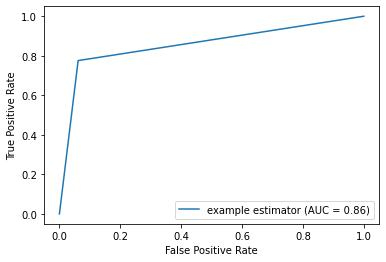

In [36]:
# ROC CURVE FOR LOGISTIC REGRESSION

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # libraries already loaded above 
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy import array 
# from sklearn import metrics

# Labels are the values we want to predict
logreg_labels = np.array(y_val['quart_binary'])

# # Instantiate model using values from our gridsearch best model
# logreg = LogisticRegression(random_state=17, penalty="l2", C=0.1, solver="sag", max_iter=10)

# # commenting out - we already ran above
# # Fit the model on training data
# logreg.fit(x_train, y_train['quart_binary'])

# # commenting out - we already ran above
# # Predict method on the test data
# # store as an array so we can plot on ROC curve 
# lr_pred = np.array(logreg.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
logreg_predictions = np.stack(lr_pred).astype(None)

logreg_fpr, logreg_tpr, logreg_thresholds = metrics.roc_curve(logreg_labels, logreg_predictions, pos_label='1')

logreg_roc_auc = metrics.auc(logreg_fpr, logreg_tpr)
logreg_display = metrics.RocCurveDisplay(fpr=logreg_fpr, tpr=logreg_tpr, roc_auc=logreg_roc_auc,
                                   estimator_name='example estimator')
logreg_display.plot()

plt.show()

**ROC Curve: Gaussian Naive Bayes**

In [37]:
# get parameters for SVM(support vector machine)
df_lr = df_classifier[df_classifier['classifier'].str.contains("Gaussian")]
df_lr = df_lr.sort_values(by="mean_test_score", ascending=False).head(1)
df_lr
df_lr.style.set_properties(subset=['param_classifier'], **{'width': '300px'})

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,classifier,classifier__criterion,classifier__max_depth,classifier__max_features,classifier__n_estimators,classifier__C,classifier__max_iter,classifier__penalty,classifier__solver
204,0.186103,0.013134,0.051063,0.008013,GaussianNB(),nan,nan,nan,nan,nan,nan,nan,nan,0.836200,0.838300,0.831700,0.836600,0.828800,0.834320,0.003519,205,GaussianNB(),0,0.000000,0,0.000000,0.000000,0.000000,0,0


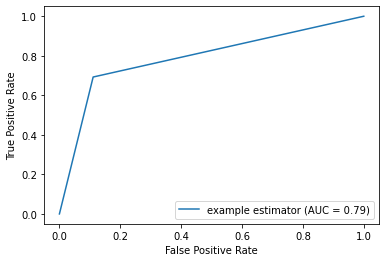

In [38]:
# ROC CURVE FOR GAUSSIAN NAIVE BAYES

# this is a little repetitive (we already fit above)
# keeping logic for future reference

# # libraries already loaded above 
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy import array 
# from sklearn import metrics

# Labels are the values we want to predict
gnb_labels = np.array(y_val['quart_binary'])

# Instantiate model using values from our gridsearch best model
# classifier_gnb = GaussianNB()

# # commenting out - we already ran above
# # Fit the model on training data
# classifier_gnb.fit(x_train, y_train['quart_binary'])

# # Predict on the validate data
# # store as an array so we can plot on ROC curve 
# gnb_pred_stg = np.array(classifier_gnb.predict(x_val))

# need to store our predictions in different format so that the ROC curve will plot 
gnb_predictions = np.stack(gnb_pred).astype(None)

gnb_fpr, gnb_tpr, gnb_thresholds = metrics.roc_curve(gnb_labels, gnb_predictions, pos_label='1')

gnb_roc_auc = metrics.auc(gnb_fpr, gnb_tpr)
display = metrics.RocCurveDisplay(fpr=gnb_fpr, tpr=gnb_tpr, roc_auc=gnb_roc_auc,
                                   estimator_name='example estimator')
display.plot()

plt.show()

### Feature importance: classification task

The random forest model performs best of the three classification models; we will interpret features below. 

Note: there are no coefficients for random forest model.
Additional note: While radom forest has highest accuracy, it does have a much longer run-time. 

In [39]:
classifier_rf.feature_importances_

array([5.84132734e-03, 1.27509045e-01, 2.06150558e-02, 4.33411373e-03,
       3.71006511e-03, 5.10873524e-02, 2.62409668e-01, 2.49867588e-02,
       1.68566414e-02, 4.04593116e-02, 7.83231452e-03, 7.64310653e-03,
       2.51929364e-03, 7.83557450e-04, 1.50496105e-02, 1.11819007e-04,
       6.00470739e-03, 5.25811471e-05, 1.93095489e-05, 3.51035521e-01,
       5.11388397e-02])

Feature: assists          Score: 0.00584
Feature: boosts           Score: 0.12751
Feature: damageDealt      Score: 0.02062
Feature: DBNOs            Score: 0.00433
Feature: headshotKills    Score: 0.00371
Feature: heals            Score: 0.05109
Feature: killPlace        Score: 0.26241
Feature: kills            Score: 0.02499
Feature: killStreaks      Score: 0.01686
Feature: longestKill      Score: 0.04046
Feature: matchDuration    Score: 0.00783
Feature: numGroups        Score: 0.00764
Feature: rankPoints       Score: 0.00252
Feature: revives          Score: 0.00078
Feature: rideDistance     Score: 0.01505
Feature: roadKills        Score: 0.00011
Feature: swimDistance     Score: 0.00600
Feature: teamKills        Score: 0.00005
Feature: vehicleDestroys  Score: 0.00002
Feature: walkDistance     Score: 0.35104
Feature: weaponsAcquired  Score: 0.05114


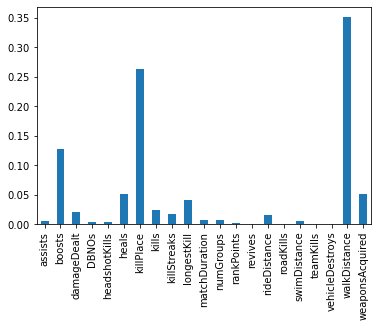

In [40]:
# code adapted from: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = classifier_rf.feature_importances_
forest_importance = pd.Series(importance, cols_df[0:23])

# summarize feature importance
for name, v in forest_importance.items():
    print('Feature: {} Score: {:.5f}'.format(name.ljust(16), v))

# plot feature importance
forest_importance.plot.bar()
plt.show()

The features with highest importance are *walkDistance*, *killPlace*, and *boosts*. These are similar results to our initial findings in the mini-lab.

1. walkDistance: This variable represents the total distance walked by a player during the match. It makes sense that the walk distance would be an imporant factor for influencing the target variable (quart_binary); a player that places higher would be alive longer, and travel a greater distance, as compared to players that place lower (aka die early).

2. killPlace: This variable represents a ranking in a given match, based on the number of enemy players killed. More enemy players killed means a better placement. It makes sense that this would be influential for our target variable, destroying a greater number of the other players means that there are fewer players to place higher than you. Additional research into analysis performed by others suggests that very few players adopt a 'passive' strategy (one in which they do not go on the offensive, attacking other players), and that even fewer manage to place highly in a given match when they have a minimal enemy kill count.

3. boosts: Boosts are items that give players extra "boosts" of life; so if a player's health is diminished, they can use boost items to replenish their health, which in turn allows them to continue to play longer, which increases the chances that they will place higher.

## Task 2: Regression models

### Hyperparameter tuning: Regression model

In [41]:
# Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 1
from sklearn.base import BaseEstimator, RegressorMixin

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 1)
# Credit to Dr. Drew: https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

In [42]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.svm import SVR

#Create scorers for MAE functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)

In [43]:
pipe_lr = Pipeline([("scaler", StandardScaler()),
                    ("classifier", CappedLinearRegression())])
pipe_svr = Pipeline([("scaler", StandardScaler()),
                     ("classifier", SVR())])
pipe_lasso = Pipeline([("scaler", StandardScaler()),
                       ("classifier", Lasso(random_state=17))])

lr_param = [{"classifier": [CappedLinearRegression()],
             "classifier__fit_intercept": [True, False],
             "classifier__normalize":[True, False]
            }
]

lasso_param = [{"classifier": [Lasso()],
                "classifier__alpha": np.logspace(-2,2,5), #cannot set alpha=0 since that would be linear regression
                "classifier__fit_intercept": [False, True],
                "classifier__normalize": [False, True],
                "classifier__max_iter": np.logspace(0,4,5),
                "classifier__selection": ['cyclic', 'random']
               }
]

svr_param = [{"classifier": [SVR()],
              "classifier__kernel": ["linear","rbf","sigmoid"],
              "classifier__max_iter": np.logspace(0,3,4),
              "classifier__C": np.logspace(-1,4,6),
              "classifier__gamma": ['scale','auto']
             }
]

**Tune Multi-Linear Regression**

In [44]:
gridsearch = GridSearchCV(pipe_lr, lr_param, cv = 5, verbose = 0, n_jobs = -1, scoring=mae_scorer)
bestLR_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

In [45]:
gridsearch = GridSearchCV(pipe_lr, lr_param, cv = 5, verbose = 0, n_jobs = -1, scoring=mae_scorer)
bestLR_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

In [46]:
print(bestLR_model.best_estimator_)
print("The mean absolute error of the model is:", bestLR_model.score(x_tune, y_tune['winPlacePerc']))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 CappedLinearRegression(fit_intercept='True',
                                        normalize='True'))])
The mean absolute error of the model is: -0.09125374257564545


**Tune LASSO Regression**

In [47]:
gridsearch = GridSearchCV(pipe_lasso, lasso_param, cv = 5, verbose = 0, n_jobs = 8, scoring=mae_scorer)
bestLASSO_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.8509521484375, tolerance: 0.4727289378643036
  model = cd_fast.enet_coordinate_descent(


In [48]:
print(bestLASSO_model.best_estimator_)
print("The mean absolute error of the model is:",bestLASSO_model.score(x_tune, y_tune['winPlacePerc']))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', Lasso(alpha=0.01, max_iter=10.0))])
The mean absolute error of the model is: -0.10081980377435684


**Tune Support Vector Regression**

In [49]:
gridsearch = GridSearchCV(pipe_svr, svr_param, cv = 5, verbose = 0, n_jobs = -1, scoring=mae_scorer)
bestSVR_model = gridsearch.fit(x_tune, y_tune['winPlacePerc'])

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [50]:
print(bestSVR_model.best_estimator_)
print("The mean absolute error of the model is:",bestSVR_model.score(x_tune, y_tune['winPlacePerc']))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVR(max_iter=1000.0))])
The mean absolute error of the model is: -0.09106828169510284


In [53]:
df_reg = pd.DataFrame(bestLR_model.cv_results_)
df_reg = df_reg.append(pd.DataFrame(bestSVR_model.cv_results_), ignore_index=True)
df_reg = df_reg.append(pd.DataFrame(bestLASSO_model.cv_results_), ignore_index = True)

In [54]:
df_reg['param_classifier'] = df_reg['param_classifier'].astype(str)

clf_result = pd.DataFrame([])
model = ["CappedLinearRegression", "Lasso", "SVR"]

for i in model:
    df_model = df_reg[df_reg['param_classifier'].str.contains(i)]
    df_model[['model']] = i
    df_model[['total_fit_time']] = np.sum(df_model[['mean_fit_time']])
    df_model = df_model[["model","total_fit_time","mean_fit_time","params", "mean_test_score"]].sort_values(
        by="mean_test_score", ascending=False).head(1)

    clf_result = clf_result.append(df_model, ignore_index = True)

clf_result
clf_result.style.set_properties(subset=['params'], **{'width': '250px'})

,model,total_fit_time,mean_fit_time,params,mean_test_score
0,CappedLinearRegression,0.364620,0.090959,"{'classifier': CappedLinearRegression(fit_intercept='True', normalize='True'), 'classifier__fit_intercept': 'True', 'classifier__normalize': 'True'}",-0.091298
1,Lasso,25.147403,0.130251,"{'classifier': Lasso(alpha=0.01, max_iter=10.0), 'classifier__alpha': 0.01, 'classifier__fit_intercept': True, 'classifier__max_iter': 10.0, 'classifier__normalize': False, 'classifier__selection': 'cyclic'}",-0.100839
2,SVR,518.355386,17.174954,"{'classifier': SVR(max_iter=1000.0), 'classifier__C': 1.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__max_iter': 1000.0}",-0.109514


## Model analysis: Fit models & confusion matrices for regression models

**Capped Linear Regression**

In [60]:
classifier_clr = CappedLinearRegression(fit_intercept=True, normalize=True)
classifier_clr.fit(x_train, y_train['winPlacePerc'])
clr_pred = classifier_clr.predict(x_val)
acc_clr = mean_absolute_error(y_val['winPlacePerc'], clr_pred)

print("Mean absolute error for Capped Linear Regression is {}".format(acc_clr))

Mean absolute error for Capped Linear Regression is 0.09077530354261398


**Lasso Regression**

In [61]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

classifier_las = Lasso(alpha=0.01, max_iter=10, fit_intercept="True", selection="cyclic")
classifier_las.fit(x_train, y_train['winPlacePerc'])
las_pred = classifier_las.predict(x_val)

mae_las = mean_absolute_error(y_val["winPlacePerc"], las_pred)
print("Mean absolute error for Lasso is {}".format(mae_las,))

Mean absolute error for Lasso is 0.096245676279068


**Support Vector Machine Regression**

In [62]:
classifier_svr = SVR(C=0.1, gamma="auto", max_iter=1000, kernel="rbf")
classifier_svr.fit(x_train, y_train['winPlacePerc'])
svr_pred = classifier_svr.predict(x_val)

mae_svr = mean_absolute_error(y_val['winPlacePerc'], svr_pred)
print("Mean absolute error for SVR is {}".format(mae_svr))

Mean absolute error for SVR is 0.2690106262535688


# **MODEL ADVANTAGES**

*Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.*

1. Classification task: When we look at the ROC curves for our classification tasks, we can see that the Random Forest model has the most area under the curve, therefore we can say with statistical certainty that the Random Forest model is the best for our classification task.

2. Classification task: We chose Random Forest as our best-performing model, but an argument could be made to change that assessment and choose the Logistic Regression model as the best. Why? Although Random Forest has the higher accuracy (around 91%), it takes about 15 minutes to run. Logistic Regression, on the other hand, only takes about 20 seconds to run, with an accuracy score of around 89%. The tradeoff in execution time may be worth the slight drop in accuracy.

1. Regression task: The capped linear regression appeared to have the lowest mean absolute error. This is the optimal model in terms of score. The support vector regression appears unable to compete both in terms of mean absolute error & in terms of run-time. Regression tasks appear better suited to other tools such as multiple linear regression and LASSO (in this particular case).

# **MODEL PERFORMANCE ON UNSEEN DATA (TEST)**

In this section we will see how well our best models generalize to unseen data, by making predictions on our TEST data.

**Classification task: Random Forest**

In [63]:
# we already fit the model on the train data earlier 
# do not need to repeat that step here

# classifier_rf = RandomForestClassifier(random_state=17, n_estimators=200, criterion="entropy", max_features="log2", max_depth=9)
# classifier_rf.fit(x_train, y_train['quart_binary'])

rf_pred_test = classifier_rf.predict(x_test)
cm_rf_test = confusion_matrix(y_test['quart_binary'], rf_pred_test)
acc_rf_test = accuracy_score(y_test['quart_binary'], rf_pred_test) * 100
print("Confusion matrix of Random Forest Classifier is:")
print(cm_rf_test)
print("The score accuracy of Random Forest Classifier is {}%".format(round(acc_rf_test,2)))

Confusion matrix of Random Forest Classifier is:
[[191861  12716]
 [ 12023  57916]]
The score accuracy of Random Forest Classifier is 90.99%


**Regression task: Lasso Regression**

In [65]:
las_pred_test = classifier_las.predict(x_test)
mae_las_test = mean_absolute_error(y_test["winPlacePerc"], las_pred_test)
print("Mean absolute error for Lasso is {}".format(mae_las_test))

Mean absolute error for Lasso is 0.09625202417373657


# **DEPLOYMENT**

**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?** 

Our models could be quite useful for different companies or organizations interested in putting together an e-sport betting portfolio.

**How would you measure the model's value if it was used by these parties?**

When we look at the ROC curves for our classification tasks, we can see that the Random Forest model has the most area under the curve, therefore we can say with statistical certainty that the Random Forest model is the best for our classification task.

As our prediction algorithms succeed or fail, we would be required to further tune our models. But the obvious metric from a gambling perspective would be the net gain to net loss ratio in dollars.

**How would you deploy your model for interested parties?** 

We could look to incorporate real-time information uploads to the model during tournament gameplay. Since PUBG gives out certain data via their PUBG Developer API, we should be capable to capturing the needed information and running evaluation metrics.

**What other data should be collected?** 

One of the most pertinent pieces of information that could be included would be average survival time in-match. This would allow us to look at predicting how long a player may survive for. This could heavily influence prediction capabilities.

**How often would the model need to be updated, etc.?**

The model would likely need to be updated every tournament cycle. We could look at more frequent updates or cross-platform deployment.

# **EXCEPTIONAL WORK**

1. Grid search = gridsearchCV used to tune hyperparameters.
2. Adding new features = we built new variables for our models to predict (quart_binary is a new attribute we generated for the classification task).
3. Data pre-processing and feature selection to optimize run-times (this was huge for us—so I'm proud of our updates to the dataset).
4. Post-hoc analysis and data manipulation for ease of display.
5. Attempts at mlxtend for 2-sample ttest were made. Significant issues were encountered with not enough resources available to troubleshoot. It appears that pipelines cannot be passed to mlxtend.evaluate.paired_ttest_5x2cv... though this was not apparent in any github notes.
